# Les centres d'intérêts des députés influencent-ils leur participation aux séances en commission permanente ? (16/12/2018)


## Introduction

Introduction ici: contexte général

plan (pas tout à fait au point encore)

1. preprocessing
2. faire tourner l'algo
3. postestimation (nombre de clusters et compagnie)
4. applications
    4.1 quels sont les centres d'intérêt des députés ? 
    4.2 à quel(s) député(s) se réfèrent ces thématiques ? 
    
5. ouverture pour un truc d'écono mais pas le temps ici
 


In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Identifier les différentes thématiques débattues

Première chose : créer les catégories thématiques (regrouper les champs lexicaux). Point de départ : 8 clusters

On utilise toutes les interventions en séance en commission pour inférer les thématiques débattues. 

Nous utilisons un script autonome pour extraire les données à partir d'une base SQL (cf. annexes)

In [30]:
import pandas 
import numpy as np

# sauf qu'en fait dans cette partie il ne faut pas utiliser ce fichier mais l'autre avec les séances LOL 
# (bon normalement on a VRAIMENT fait le plus dur maintenant)
# il faut prendre les bons indices

#Attention à indiquer l'emplacement local du fichier words_mps.txt (accessible en local uniquement)

df=pandas.read_csv('/Users/Gabriel/Desktop/words_meetings.txt', sep='\t',header=None)
#df = pandas.read_csv('/Users/Hugo/Documents/Cours/ENSAE/Python/python_deputes/words_mps.txt', sep='\t',header=None,na_filter=False)

df1 = df.values

df.head()

,0,1,2
0,3,145,J'invite les deux plus jeunes commissaires pré...
1,3,145,Je constate qu'il n'y a qu'un seul candidat. I...
2,3,77,Nous en venons à l'élection des quatre vice-pr...
3,3,77,"Pour les postes de secrétaires, j'ai reçu les ..."
4,3,77,"MM. Stéphane Demilly, Jacques Kossowski, Arnau..."


#### Régularisation du texte

Avant d'appliquer l'algorithme, on retravaille le fichier de manière à n'en conserver que les mots clefs. Pour cela, on enlève les stop-words ainsi qu'un certain nombre d'expressions redondantes, la ponctuation et on homogénéise de sorte que tout soit saisi en minuscules.

In [31]:
import pandas
import numpy as np

#homogénéisation: tout en minuscules, et enlever la ponctuation
ponctuation=["l'","j'"," mme "," m "," mm "," m'"," c'"," j'"," s'"," n'"," d'"," l'",'!','"','#','$','%','&','(',')','*','+',',','.','/',':',';','<','=','>','?','@','[',']','^','_' , '`' , '{' , '|' , '}','~' , '}','«','»',"1er"]

chiffres=[]
for i in range(9):
    chiffres.append(str(i))

for i in range(len(df1)):
    ligne=df1[i,2]
    ligne=ligne.lower()
    for w in range(len(ponctuation)):
        ligne=ligne.replace(ponctuation[w]," ")
    for x in range(len(chiffres)):
        ligne=ligne.replace(chiffres[x],"")        
    df1[i,2]=ligne  

# on fait une deuxixème fois car la première ça ne semble ne pas marcher. Pourquoi ? 

for i in range(len(df1)):
    ligne=df1[i,2]
    ligne=ligne.lower()
    for w in range(len(ponctuation)):
        ligne=ligne.replace(ponctuation[w]," ")
    for x in range(len(chiffres)):
        ligne=ligne.replace(chiffres[x],"")        
    df1[i,2]=ligne      

In [35]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer


#mots récurrents (corpus stop words: source: PHP de Regards Citoyens)
stop_liste=["n°","l'","j'","les","ayant","grand-chose","après-midi", "au-delà", "devant", "octobre", "novembre", "action", "assemblée", "activité", "besoin", "définition", "adopté", "député", "spéciale", "spécial", "rappelle", "hong", "précédente", "information", "délai", "applicable", "expliqué", "propose", "relative", "indique", "vingt", "janvier", "puis", "jour", "lecture", "séance", "alinéa", "résolution", "adoption", "collègue", "cher", "collègues", "chers","bis", "  er", "rectifié", "question", "rédactionnel", "scrutin", "exposer", "identiques", "identique", "commission", "adopte", "rejette", "additionnel", "tendant", "examiné", "examine", "rejeté", "avis", "suivant", "estimé", "déclaré", "parce", "beaucoup", "afin", "madame", "sous", "bonne", "monsieur", "quelle", "quinze", "lors", "là", "long", "messieurs", "ici", "trois", "êtes", "serait", "seront", "dix", "mot", "vin", "mon", "hier", "date", "cinq", "celui", "allez", "après", "bureau", "cause", "sous-amendement", "certaine", "chose", "code", "compris", "général", "pris", "demande", "jeudi", "jamais", "juillet", "mois", "plusieurs", "mardi", "mercredi", "lundi", "quatre", "semaine", "suppression", "semble", "souvent", "vers", "jamais", "comité", "discussion", "liens", "lieux", "membres", "vendredi", "dernière", "donner", "délégation", "défendu", "défavorable", "exemple", "favorable", "fonction", "grand", "habitant", "haut", "juridique", "mars", "membre", "mettre", "mise", "ministère", "mission", "niveau", "oui", "organique", "objet", "notion", "norme", "pense", "première", "prendre", "principe", "procédure", "puisque", "rien", "sceaux", "réponse", "spécial", "vise", "vos","vote", "suppresion", "urgence", "rapporteur", "rapporteure", "décembre", "dans", "aujourd’hui", "j'ai", "l'on", "n'a", "qu'elle", "qu'il", "s'agit","mr", "mme","vice-président","si","mais","où","et","or","ni","car","que","que","quoi","donc","ou","amendement","l'amendement","du","cet","ils","elles","cette","cela","ce","cela","celui","sinon","ça","sa","se","ma","mon","mes","ta","ton","tes",'être',"avoir","faire","ai","es","est","êtes","sommes","sont","as","a","avons","avez","ont","fais","fait","faisons","faisez","faîtes","avais","avait","avions","aviez","avaient","étais","était","étions","étiez","étaient","faisais","faisait","faisions","faisiez","faisaient"]
#stop_liste=["n°","l'","j'","les","ayant","grand-chose","après-midi", "au-delà", "devant", "octobre", "novembre", "action", "assemblée", "activité", "besoin", "définition", "adopté", "député", "spéciale", "spécial", "rappelle", "hong", "précédente", "information", "délai", "applicable", "expliqué", "propose", "relative", "indique", "vingt", "janvier", "puis", "jour", "lecture", "séance", "alinéa", "résolution", "adoption", "collègue", "cher", "collègues", "chers","bis", "  er", "rectifié", "question", "rédactionnel", "scrutin", "exposer", "identiques", "identique", "commission", "adopte", "rejette", "additionnel", "tendant", "examiné", "examine", "rejeté", "avis", "suivant", "estimé", "déclaré", "parce", "beaucoup", "afin", "madame", "sous", "bonne", "monsieur", "quelle", "quinze", "lors", "là", "long", "messieurs", "ici", "trois", "êtes", "serait", "seront", "dix", "mot", "vin", "mon", "hier", "date", "cinq", "celui", "allez", "après", "bureau", "cause", "sous-amendement", "certaine", "chose", "code", "compris", "général", "pris", "demande", "jeudi", "jamais", "juillet", "mois", "plusieurs", "mardi", "mercredi", "lundi", "quatre", "semaine", "suppression", "semble", "souvent", "vers", "jamais", "comité", "discussion", "liens", "lieux", "membres", "vendredi", "dernière", "donner", "délégation", "défendu", "défavorable", "exemple", "favorable", "fonction", "grand", "habitant", "haut", "juridique", "mars", "membre", "mettre", "mise", "ministère", "mission", "niveau", "oui", "organique", "objet", "notion", "norme", "pense", "première", "prendre", "principe", "procédure", "puisque", "rien", "sceaux", "réponse", "spécial", "vise", "vos","vote", "suppresion", "urgence", "rapporteur", "rapporteure", "décembre", "dans", "aujourd’hui", "j'ai", "l'on", "n'a", "qu'elle", "qu'il", "s'agit","mr", "mme","vice-président","si","mais","où","et","or","ni","car","que","que","quoi","donc","ou","amendement","l'amendement","du","cet","ils","elles","cette","cela","ce","cela","celui","sinon","ça","sa","se","ma","mon","mes","ta","ton","tes",'être',"avoir","faire","ai","es","est","êtes","sommes","sont","as","a","avons","avez","ont","fais","fait","faisons","faisez","faîtes","avais","avait","avions","aviez","avaient","étais","était","étions","étiez","étaient","faisais","faisait","faisions","faisiez","faisaient","qu","visent","il","elle","doit","notamment","dont","nous","vous","je","elle","il","ils","elles","tu","non","projet","cl","cf","sans","avec","très","proposition","propositions","tout","tous","ans","autres","autre","agit",]

stop_w=stopwords.words('french')

fr = SnowballStemmer('french')

for i in range(len(stop_liste)):
    stop_w.append(stop_liste[i])

stop_words = set(stop_w)     
#enlever les stop words dans chacune des interventions

for i in range(len(df1)):
    
    tokens = word_tokenize(df1[i,2])
    
    filtered_sentence=[]
    for w in tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)

            
# Stemmatisation --- a passer en commentaire si nécessaire
#+ itérer sur filtered_sentence et pas mots_stem derrière

    mots_stem=[]
    for u in range(len(filtered_sentence)):
        mots_stem.append(fr.stem(filtered_sentence[u]))
        
    string_propre=""
    for j in range(len(mots_stem)):
        string_propre=string_propre+" "+mots_stem[j]
        
    df1[i,2]=string_propre

In [36]:
for i in range(3):
    print(df1[i,2])

 invit deux plus jeun commissair présent julien aubert guillaum larriv ven sieg rempl secrétair âge âge constitu ordre appel mainten nomin conform articl 9 regl comprend outr président secrétair term articl 9 regl compos chaqu efforc reproduir configur pol assur représent tout compos alin articl précisent comm élus secret catégor lorsqu chaqu catégor nombr candidat supérieur nombr sieg pourvoir proced major absolu acquis deux prem tour major suff troisiem tour cas égal suffrag plus âgé nomm exist aucun préséanc entre enfin articl ° instruct dispos déleg droit peuvent effet secret chaqu commissair voudront bien appel nom bulletin urne allon abord proced élect président invit ceux acte candidatur connaîtr
 constat qu'un seul candidat lieu proced conséquent jean-paul chanteguet élu président invit plac fauteuil présidentiel applaud
 venon élect vice-président candidat connaîtr françois-michel lambert group écolog christoph bouillon group social républicain citoyen src alain gest group uni

In [37]:
#suite ici 
#on pourrait essayer de lemmatiser si le temps et les moyens le permettent. 
#demander à Dupré comment on lemmatise en français 

On génère la donnée d'entrée de l'algorithme : 

In [38]:
#on crée la liste de propositions à classifier

#liste complète (assez longue à faire)
documents=[]
for z in range(len(df1)):
    documents.append(df1[z,2])
    

Récupérer les stop words ihérents au document à partir du count vectorizer

Modifier la base de données de base à partir des mots récurrents identifiés

On passe à l'algorithme à proprement parler : 

In [43]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

#Première initialisation du nombre de clusters: le nombre de commissions

start_time = time.time()
true_k = 10

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
out=model.fit(X)

elapsed_time = time.time() - start_time

In [44]:
elapsed_time

257.89621686935425

Des résultats préliminaires :

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i,)
    for ind in order_centroids[i, :30]:
        print (' %s' % terms[ind],)
    print()

Top terms per cluster:
Cluster 0:
 vous
 franc
 il
 plus
 quel
 qu
 pay
 comment
 el
 est
 autr
 tout
 économ
 comm
 part
 peut
 développ
 tres
 entre
 polit
 certain
 état
 not
 auss
 rapport
 bien
 énerg
 avez
 mati
 import

Cluster 1:
 loi
 projet
 text
 proposit
 disposit
 financ
 plus
 tout
 gouvern
 qu
 publiqu
 rapport
 droit
 comm
 group
 présent
 examen
 président
 ministr
 conseil
 débat
 social
 articl
 appliqu
 travail
 part
 état
 sujet
 national
 autr

Cluster 2:
 euros
 million
 milliard
 financ
 crédit
 dépens
 plus
 budget
 anné
 état
 mont
 impôt
 augment
 coût
 baiss
 programm
 fiscal
 recet
 an
 mesur
 social
 gouvern
 économ
 rapport
 compt
 part
 projet
 invest
 budgétair
 qu

Cluster 3:
 entrepris
 salari
 travail
 accord
 social
 emploi
 plus
 employeur
 qu
 disposit
 économ
 tout
 heur
 il
 temp
 loi
 peut
 négoci
 format
 compt
 entre
 droit
 autr
 part
 branch
 tres
 certain
 comm
 impôt
 mesur

Cluster 4:
 européen
 union
 europ
 pay
 franc
 plus
 polit
 éta

## Évaluation du modèle

### Visualisation des clusters, évaluation de la performance du modèle

[[-196.94327  -555.6186  ]
 [-600.2177   -318.12772 ]
 [-344.4969    485.51834 ]
 [-665.83685   145.26518 ]
 [ 121.89041   446.4922  ]
 [ 240.24988  -388.59424 ]
 [-151.9057    -18.232292]
 [ 382.01422    57.430416]]


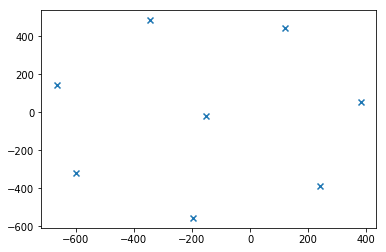

In [11]:
#visualiser les trucs

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

centroids = out.cluster_centers_

tsne_init = 'pca'  # could also be 'random'
tsne_perplexity = 20.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
random_state = 1
model = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
         early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

transformed_centroids = model.fit_transform(centroids)
print(transformed_centroids)
plt.scatter(transformed_centroids[:, 0], transformed_centroids[:, 1], marker='x')
plt.show()

In [ ]:
#ici mettre les indices (Davies Boulin et compagnie par exemple)

### Ajuster le nombre de clusters

In [ ]:
# Tester la sélection de clusters et voir comment évoluent les performances du modèle

### Sélection du modèle final

## Déduire les préferences des députés

On utilise le modèle que l'on a entrainé sur les interventions en commission pour attribuer à chaque député un profil de préférence en se fondant sur ses interventions en hémicycle.

In [30]:
import pandas 
import numpy as np

#ce coup-ci c'est le bon emplacement 

#Attention à indiquer l'emplacement local du fichier words_mps.txt (accessible en local uniquement)

df=pandas.read_csv('/Users/Gabriel/Desktop/words_mps.txt', sep='\t',header=None)
#df = pandas.read_csv('/Users/Hugo/Documents/Cours/ENSAE/Python/python_deputes/words_mps.txt', sep='\t',header=None,na_filter=False)

df1 = df.values

df.head()

,0,1,2
0,3,145,J'invite les deux plus jeunes commissaires pré...
1,3,83,"Au nom du groupe socialiste, républicain et ci..."
2,3,145,Je constate qu'il n'y a qu'un seul candidat. I...
3,3,77,Nous en venons à l'élection des quatre vice-pr...
4,3,77,"Pour les postes de secrétaires, j'ai reçu les ..."


In [ ]:
#prochaines étapes: pour chaque député dire à quelle catégorie correspondait l'intervention
#puis calculer les fréquences
#aller ensuite chercher en vitesse le tableau des noms et coller les noms avec les ids

In [ ]:
## s'inspirer de cette partie pour prédire les préférences: 

#faire un matrice avec une colonne n° du député, une autre n° du cluster

Y = vectorizer.transform(["chrome browser to open."])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["My cat is hungry."])
prediction = model.predict(Y)
print(prediction)

In [ ]:
#trouver une pondération pour inférer les préfences du député

### Quelques statistiques sur les préférences des députés

In [ ]:
#normalement là tout est bon, on peut utiliser le modèle

## Applications

### Quels sont les centres d'intérêts des députés ?

En entrée: on donne un député
par exemple, l'utilisateur renseigne son adresse, on en déduit le député du cru et les questions qu'il aime traiter
Par exemple, à partir d'informations personnelles, on renseigne par exemple sa commune ou son département, on nous dit quels sont les centres d'intérêt du député du cru

### Quel député pour quelle thématique ? 

En entrée: on donne une thématique, l'algo nous dit vers qui se tourner (par exemple envoyer une adresse mail) 
Par exemple si on veut savoir à quel député s'adresser pour en savoir plus sur une thématique précise 

bon après on peut aussi imaginer un truc de l'espace où à partir des cookies du mec on lui recommande des députés à qui il faut qu'il s'adresse s'il veut en savoir plus sur un sujet donné, en utilisant notamment toute l'information (et pas juste les préférences sur le député, comme par exemple les rapports qu'il a produit et compagnie) 

## Extensions 

Une autre extension du modèle peut être d'utiliser le profil de préférences généré pour voir s'il permet de prédire voire s'il cause la présence en commission. 

In [31]:
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
lemmatizer = FrenchLefffLemmatizer()
lemmatizer.lemmatize("J'invite les deux plus jeunes commissaires",all)

("J'invite les deux plus jeunes commissaires", 'np')

In [25]:
print(type(df_))
print(type(df_1))
print(type(df_2))
print(df_2.shape)
for i in range (0,5839) :
    z = df_2[i,1]
    z1 = repr(z)
    z1 = z1.replace("</p>","")
    z1 = z1.replace('"<p>',"")
    z1 = z1.replace("('<p>","")
    z1 = z1.replace("',)(","")
    z1 = z1.replace('",)(','')
    z1 = z1.replace('",)','')
    z1 = z1.replace("',)",'')
    z1 = z1.replace("<p>",'')
    z1 = z1.replace("'"," ")
    z1 = z1.replace("!",'')
    z1 = z1.replace(".",' ')
    z1 = z1.replace("\\",'')
    df_2[i,1] = z1
print(df_2) 


<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(5839, 2)
[[3
  ' (Commission du développement durable et de l aménagement du territoirePrésidence de M  Jacques Kossowski, président d âgeJ invite les deux plus jeunes commissaires présents, MM  Julien Aubert et Guillaume Larrivé, à venir siéger au bureau pour y remplir les fonctions de secrétaires d âge Le bureau d âge est constitué L ordre du jour appelle maintenant la nomination du bureau de la Commission, conformément à l article 39 du Règlement  Ce bureau comprend, outre le président, quatre vice-présidents et quatre secrétaires  Aux termes de l article 39 du Règlement, « la composition du bureau de chaque commission s efforce de reproduire la configuration politique de l Assemblée et d assurer la représentation de toutes ses composantes »  Les alinéas 4 à 6 du même article précisent que « les bureaux des Commissions sont élus au scrutin secret par catégorie de fonction  Lorsque, pour chaque cat

In [18]:
# on enlève les stop-words et on tokénise. En somme on bigdate
import nltk
# nltk.download('stopwords') 
# [Gab il faut que tu télécharges ça, je le mets en commentaire car je l'ai déjà fait]
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_w=stopwords.words('french')
#stop_w=.append(stop_w=.append("ayant","grand-chose","après-midi", "au-delà", "devant", "octobre", "novembre", "action", "assemblée", "activité", "besoin", "définition", "adopté", "député", "spéciale", "spécial", "rappelle", "hong", "précédente", "information", "délai", "applicable", "expliqué", "propose", "relative", "indique", "vingt", "janvier", "puis", "jour", "lecture", "séance", "alinéa", "résolution", "adoption", "collègue", "cher", "collègues", "chers","bis", "  er", "rectifié", "question", "rédactionnel", "scrutin", "exposer", "identiques", "identique", "commission", "adopte", "rejette", "additionnel", "tendant", "examiné", "examine", "rejeté", "avis", "suivant", "estimé", "déclaré", "parce", "beaucoup", "afin", "madame", "sous", "bonne", "monsieur", "quelle", "quinze", "lors", "là", "long", "messieurs", "ici", "trois", "êtes", "serait", "seront", "dix", "mot", "vin", "mon", "hier", "date", "cinq", "celui", "allez", "après", "bureau", "cause", "sous-amendement", "certaine", "chose", "code", "compris", "général", "pris", "demande", "jeudi", "jamais", "juillet", "mois", "plusieurs", "mardi", "mercredi", "lundi", "quatre", "semaine", "suppression", "semble", "souvent", "vers", "jamais", "comité", "discussion", "liens", "lieux", "membres", "vendredi", "dernière", "donner", "délégation", "défendu", "défavorable", "exemple", "favorable", "fonction", "grand", "habitant", "haut", "juridique", "mars", "membre", "mettre", "mise", "ministère", "mission", "niveau", "oui", "organique", "objet", "notion", "norme", "pense", "première", "prendre", "principe", "procédure", "puisque", "rien", "sceaux", "réponse", "spécial", "vise", "vos","vote", "suppresion", "urgence", "rapporteur", "rapporteure", "décembre", "dans", "aujourd’hui", "j'ai", "l'on", "n'a", "qu'elle", "qu'il", "s'agit")
stop_liste=["ayant","grand-chose","après-midi", "au-delà", "devant", "octobre", "novembre", "action", "assemblée", "activité", "besoin", "définition", "adopté", "député", "spéciale", "spécial", 'rappelle', 'hong', "précédente", "information", "délai", 'applicable', 'expliqué', 'propose', 'relative', 'indique', 'vingt', 'janvier', 'puis', 'jour', 'lecture', 'séance', 'alinéa', 'résolution', 'adoption', 'collègue', 'cher', 'collègues', 'chers','bis', '  er', 'rectifié', 'question', 'rédactionnel', 'scrutin', 'exposer', 'identiques', 'identique', 'commission', 'adopte', 'rejette', 'additionnel', 'tendant', 'examiné', 'examine', 'rejeté', 'avis', 'suivant', 'estimé', 'déclaré', 'parce', 'beaucoup', 'afin', 'madame', 'sous', 'bonne', 'monsieur', 'quelle', 'quinze', 'lors', 'là', 'long', 'messieurs', 'ici', 'trois', 'êtes', 'serait', 'seront', 'dix', 'mot', 'vin', 'mon', 'hier', 'date', 'cinq', 'celui', 'allez', 'après', 'bureau', 'cause', 'sous-amendement', 'certaine', 'chose', 'code', 'compris', 'général', 'pris', 'demande', 'jeudi', 'jamais', 'juillet', 'mois', 'plusieurs', 'mardi', 'mercredi', 'lundi', 'quatre', 'semaine', 'suppression', 'semble', 'souvent', 'vers', 'jamais', 'comité', 'discussion', 'liens', 'lieux', 'membres', 'vendredi', 'dernière', 'donner', 'délégation', 'défendu', 'défavorable', 'exemple', 'favorable', 'fonction', 'grand', 'habitant', 'haut', 'juridique', 'mars', 'membre', 'mettre', 'mise', 'ministère', 'mission', 'niveau', 'oui', 'organique', 'objet', 'notion', 'norme', 'pense', 'première', 'prendre', 'principe', 'procédure', 'puisque', 'rien', 'sceaux', 'réponse', 'spécial', 'vise', 'vos', 'vote', 'suppresion', 'urgence', "rapporteur", "rapporteure", 'décembre', 'dans', "aujourd'hui", "j'ai", "l'on", "n'a", "qu'elle", "qu'il", "s'agit"]
for i in range(len(stop_liste)):
    stop_w.append(stop_liste[i])
st = set(stop_w)
for i in range(len(df_2)) :
    z = df_2[i,2]
    z = ' - '.join(w for w in word_tokenize(z) if w not in st)
    df_2[i,2] = z
print(df_2)

[[3 145
  "J'invite - les - deux - plus - jeunes - commissaires - présents - , - MM - . - Julien - Aubert - Guillaume - Larrivé - , - venir - siéger - bureau - remplir - les - fonctions - secrétaires - d'âge.Le - bureau - d'âge - constitué.L'ordre - jour - appelle - maintenant - nomination - bureau - Commission - , - conformément - l'article - 39 - Règlement - . - Ce - bureau - comprend - , - outre - président - , - quatre - vice-présidents - quatre - secrétaires - . - Aux - termes - l'article - 39 - Règlement - , - « - composition - bureau - chaque - commission - s'efforce - reproduire - configuration - politique - l'Assemblée - d'assurer - représentation - toutes - composantes - » - . - Les - alinéas - 4 - 6 - article - précisent - « - les - bureaux - Commissions - élus - scrutin - secret - catégorie - fonction - . - Lorsque - , - chaque - catégorie - fonction - , - nombre - candidats - n'est - supérieur - nombre - sièges - pourvoir - , - n'est - procédé - scrutin - . - Si - majorité

In [20]:
print(len(df_2))

160393


## Voir comment la proximité thématique prédit la participation

## Bibliographie


<span>&#8226;</span> Benjamin Monnery & Maxime Le Bihan, 2018. "Can Public and Private Sanctions Discipline Politicians? Evidence from the French Parliament," EconomiX Working Papers 2018-21, University of Paris Nanterre, EconomiX.

<span>&#8226;</span> Wu, A. H. (2017). Gender stereotyping in academia: Evidence from economics job market rumors forum.
